# Extended Kalman Filter SLAM

# EKF Algorithm

The extended kalman filter is a recursive state estimation algorithm based on bayes filter. It can be used as a solution for Simultaneous Localisation and Mapping problem because of it's recursive nature. This is one of the easiest algorithms to implement and is hence, widely used.

In a typical SLAM problem, an environment can consist of an agent, typically a robot, and various landmarks whose locations are observed and stored to create a map of the environment. As the robot moves through the environment, it keeps estimating the locations of the environment from it's previous state and uses the observations it makes, which is through sensors like a laser range finder or a camera, to adjust it's estimates to create a more accurate model(map) of the environment.

*Note*: The state variable is modelling the environment, so not only does it consists the variables describing the agent's(or robot's) state but also the variables describing the location of each of the landmarks present in the environment. These descriptions of landmarks are generally relative to the robot's state.

Given $x_{1..t}$, the state of the environment at timesteps 1..t, and the commands $u_{1..n}$ are executed by the agent(or robot) and $z_{1..n}$ be the Observations made, then the algorithm uses such a setup to computes the beleif function `bel` which estimates the new state of the environment.

\begin{equation*}
bel(x_{t}) = P( z_{t}|x_{t} )\int_{x_{t-1}}P( x_{t} | x_{t-1} , u_{t}) bel(x_{t-1}) dx_{t-1} 
\end{equation*}

The above recursive function can be divided into two steps:
    
    1) Prediction step: Estimating the current state based on previous state and control executed.

\begin{equation*}
    \bar{bel}(x_{t}) = \int_{x_{t-1}}P( x_{t} | x_{t-1} , u_{t}) bel(x_{t-1}) dx_{t-1}
\end{equation*}

    2) Correction step: Correcting the state estimation based on estimations of current observations.
\begin{equation*}
    bel(x_{t}) = P( z_{t}|x_{t} )\bar{bel}(x_{t})
\end{equation*}
    

### Assumptions

The algorithm is a based from the Kalman Filter algorithm which makes the following **assumptions**:

        1) Motion and Observarion models are linear.
        2) Noise is distributed Normally (Gaussian Distribtion)
        
What this practically means is that we assume that we can represent the motion of the robot and the estimates of the landmark's relative positions as linear functions. However, this is mostly not the case. A robot or an agent tends to have an orientation which is naturally defined in terms of trigonometric functions and so is it's motion. Similarly, a landmarks can only be estimated by it's distance along with it's direction, which ofcourse introduces some non-linearity.

We will analyse some very common Motion and Observation models to understand this further.

# Motion and Observation Models

### Odometry Motion Model.

The motion model can be represented by a function $g()$ such that the state of the robot can be estimated from it's previous state and the control commands executed by the robot.

if $x_{t}$ is the new state and $u_{t}$ is the new control command,

\begin{equation*}
x_{t} = g(x_{t-1},u_{t}) + R_{t}
\end{equation*}

&emsp;&emsp;&emsp;&emsp;&emsp; Where, **$g()$** is the motion model of the system and $R_{t}$ represents the noise in the system.

In an Odometry Motion model, **$g()$** can be defined as follows:

\begin{equation*}
    \begin{bmatrix} x' \\ y' \\ \theta' \end{bmatrix}
    =
    \begin{bmatrix} x \\ y \\ \theta \end{bmatrix}
    +
    \begin{bmatrix} t*cos(\theta + r1) \\ t*sin(\theta + r1) \\ r1 + r2 \end{bmatrix}
\end{equation*}
![OdometryMotionModel](figures/OdometryMotionModel.png)

The Odomotery model captures the change in robot's pose using three parameters. **'r1'** which represents the angle to rotate the robot to face the destination, **'t'** which is the euclidean distance between the robot's final and current pose and **'r2'** which is the angle to rotate the robot to make it face where the final pose wants it to.


### Range and Bearing Observation Model

Landmarks are the features in an environment that the robot uses for navigation and map builiding. A landmark in an indoor applitcation may be a door, a windowsill, or edges of the walls(especially where they meet the floor). In an outdoor application, a landmark may be the trunk of a tree or edges and corners of buildings.

In a SLAM problem the robot detects these landmarks and tries to keep estimating their relative locations from itself as it explores the environment further. Since the robot has an estimate of where the landmarks it has seen before are, it can use this information to localize itself.

but how do we sense a landmark? We need to define an observation model to sense a landmark and define it's location using some variables.

An observation model estimates the environment $z$ from the robot's current state and can be defined as:

\begin{equation*}
    z_{t} = h(x_{t}) + Q_{t}
\end{equation*}

&emsp;&emsp;&emsp;&emsp;&emsp; Where, **$h()$** is the observation model of the system and $Q_{t}$ represents the noise in the system.

One of the easiest way to implement an observation model is to use a **Range and Bearing** model.

This model assumes that the robot can sense the distance and the direction to any of the landmarks in its vicinity. The distance to the landmarks is then called the *range* and the direction to the landmark is called the *bearing*.

![observationmodel](figures/ObservationModel.png)

This information can then be used to find the coordinates of the landmark using the equation below.

\begin{equation*}
    \begin{bmatrix} X' \\ Y'  \end{bmatrix}
    =
    \begin{bmatrix} x \\ y  \end{bmatrix}
    +
    \begin{bmatrix} r*cos(\phi) \\ r*sin(\phi)\end{bmatrix}
\end{equation*}

Similarly, this coordinates of the landmarks can also be used to find the range and bearing relative to the robot using the following equation :

\begin{equation*}
    \begin{bmatrix} r \\ phi  \end{bmatrix}
    =
    \begin{bmatrix} \sqrt{(X'-x)^2 + (Y'-y)^2} \\ \tan^{-1}{(\frac{Y'-y}{X'-x})} - \theta \end{bmatrix}
\end{equation*}

Both these equations are straight forward and will be used further to compare the observations made which are in range and bearing form to the state of the landmarks which is represented as coordinates.



**Both of these very 'common' models have non linear functions like sin and cos involved. Therefore these models don't adhere to the assumptions made earlier. So how do we solve this problem?**

### The essence of Extended Kalman Filter

The reason we call this algorithm the **Extended** Kalman Filter is that this algorithm is an extention of the Kalman Filter algorithm which is capable of working with non-linear models as we have seen above. Now we see how this is done.

When The models are not linear which as we have seen, is often the case, The algorithm tries to linearise the models using a linearising transformation called **First order Taylor Expansion**. The way this works is:

Instead of evaluating the value of the non-linear function, we approximate it to a linear function. This function is the tangent of the non-linear function at the mean of the gaussian. The tangent to a non-linear function can be evaluated by computing the Jacobian of that function. Therefore, for non-linear motion models,
            
            if the motion model of the agent can be described as:
    
\begin{equation*}
    x_{t} = g(x_{t-1},u_{t}) + R_{t}
\end{equation*}

            where, g() is a non-linear function and R is noise,
            then on performing linearisation,
\begin{equation*}
    g(x_{t-1},u_{t}) \approx g(\mu_{t-1},u_{t}) + G_{t}(x_{t-1}-\mu_{t-1})
\end{equation*}
            
   &emsp;&emsp;&emsp;&emsp;&emsp;where $G_{t}$ is the jacobian of g wrt x, and $\mu_{t-1}$ is the
            last best estimate of the state.
            
Similarly,
            
            if the Observation model of the agent can be described as:

\begin{equation*}
    z_{t} = h(x_{t}) + Q_{t}
\end{equation*}
            
            where h() is a non-linear function and Q is noise,
            then on performing linearisation,
\begin{equation*}
    h(x_{t-1}) \approx h(\bar{\mu_{t}}) + H_{t}(x_{t}-\bar{\mu_{t}})
\end{equation*}

   &emsp;&emsp;&emsp;&emsp;&emsp;where $H_{t}$ is the jacobian of h wrt x and $\bar{\mu_{t}}$ is the
            current best estimate of the state.
            
This process can be visualised as shown in the figure below:
    
![EKF-linearisation](figures/EKFScaled_Down.png)

## Combining Models with Gaussian assumptions we have,

As discussed before, The EKF algorithm can be divided into steps. So if we have the motion and observation models as described above then these steps can be described as follows:

            Prediction step :

\begin{equation*}
P(x_{t} | x_{t-1}, u_{t}) = det(2*\pi*\sum)^\frac{-1}{2} \exp^{\frac{-1}{2}(x_{t}-g(x_{t-1},u_{t})-G_{t}(x_{t-1} - \mu_{t-1}))\sum^{-1}(x_{t}-g(x_{t-1},u_{t})-G_{t}(x_{t-1} - \mu_{t-1}))^{T}}
\end{equation*}

&emsp;&emsp;&emsp;&emsp;&emsp; Where, $\sum$ represents the variance or uncertainity.

&emsp;&emsp;&emsp;&emsp;&emsp; Since we have modelled uncertainity as $R_{t}$ in the motion model,

&emsp;&emsp;&emsp;&emsp;&emsp; $\sum$ can be replaced by $R_{t}$

&emsp;&emsp;&emsp;&emsp;&emsp; So, modified equation is :


\begin{equation*}
P(x_{t} | x_{t-1}, u_{t}) = det(2*\pi*R_{t})^\frac{-1}{2} \exp^{\frac{-1}{2}(x_{t}-g(\mu_{t-1},u_{t})-G_{t}(x_{t-1} - \mu_{t-1}))R_{t}^{-1}(x_{t}-g(\mu_{t-1},u_{t})-G_{t}(x_{t-1} - \mu_{t-1}))^{T}}
\end{equation*}

Similaryly,

&emsp;&emsp;&emsp;&emsp;&emsp; In Observation model the uncertainity or variance is modelled by $Q_{t}$

&emsp;&emsp;&emsp;&emsp;&emsp; So, the equation becomes:

    Correction step :
\begin{equation*}
P(z_{t} | x_{t} )= det(2*\pi*Q_{t})^\frac{-1}{2} \exp^{\frac{-1}{2}(z_{t}-h(\mu_{t})-H_{t}(x_{t} - \mu_{t}))Q_{t}^{-1}(x_{t}-h(\mu_{t})-H_{t}(x_{t} - \mu_{t}))^{T}}
\end{equation*}
    

## But it gets simple..

When the math is simplified, the recursive function `bel`, which is practically the EKF algorithm, boils down to the following pseudocode:

The pseudocode for the EKF Algorithm:

ExtendedKalmanFilter ($\mu_{t-1}, \sum_{t-1}, u_{t}, z_{t})$<br>
        
        (prediction steps)
&emsp;&emsp;&emsp;&emsp;&emsp; $\bar{\mu_{t}} =  g(\mu_{t-1},u_{t})$ <br>
&emsp;&emsp;&emsp;&emsp;&emsp; $\bar{\sum}_{t} = G_{t}\sum_{t-1}$$G_{t}^T~ + R_{t}$

        (corrction steps)
        
&emsp;&emsp;&emsp;&emsp;&emsp; $K_{t} = \bar{\sum}_{t}H_{t}^T(H_{t}\bar{\sum}_{t}H_{t}^T + Q_{t})^{-1}$  (kalman gain)<br>
&emsp;&emsp;&emsp;&emsp;&emsp; $\mu_{t} = \bar{\mu}_{t} + K_{t}(z_{t} - h(\bar{\mu}_{t}))$<br>
&emsp;&emsp;&emsp;&emsp;&emsp; $\sum_{t} = (I - K_{t}H_{t})\bar{\sum}_{t}$<br><br>

&emsp;&emsp;&emsp;&emsp;&emsp; return($\mu_{t}, \sum_{t}$)

# Implementing the algorithm with data taken from friedburg university's Robotics Mapping course. Thank you for the open access.

## Data files saved from octave. Use octave to read files.

### Edit : I have written a custom function to read data. So Octave no more required.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IO.io import read_data, read_landmarks
%matplotlib inline

In [2]:
# Reading data
data = read_data('data/sensor_data.dat')
landmarks_data = read_landmarks('data/world.dat')


### As seen above. Landmarks are saved as 3 dimensional objects with dimension corresponding to [id,x,y] respc.

In [3]:
landmarks = pd.DataFrame(landmarks_data)

In [4]:
landmarks.T

,0,1,2,3,4,5,6,7,8
id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
x,2.0,0.0,2.0,9.0,10.0,9.0,5.0,5.0,5.0
y,1.0,4.0,7.0,2.0,5.0,8.0,5.0,3.0,9.0


In [5]:
odometry = data['odometry']
sensor = data['sensor']
print("Odometry: {}".format(len(odometry)))
print("Sensor: {}".format(len(sensor)))

Odometry: 330
Sensor: 330


#### The data consists of 330 timesteps with Odometry(motion) and sensor(Observation) data provided for each of the timesteps.

In [6]:
print(odometry[0])

{'r1': 0.100692392654, 'r2': 0.000171392857486, 't': 0.100072845247}


Odometry data on each timestep consists of parameters 'r1' , 't' and 'r2'.

# Observation Model: Range-Bearing

In [7]:
sensor[0]

[{'bearing': 0.374031885671, 'id': 1.0, 'range': 1.89645381418},
 {'bearing': 1.51951017943, 'id': 2.0, 'range': 3.85367751107}]

The sensor data on exploring reveals that at each time step, the sensor data consists of the Range and Bearing of the observed landmarks. Now at each timestep, the number of landmarks observed can be different, so the size of the sensor data is varying.

The data is of the form : [ ID , Range , Bearing]. Here range is the euclidean distance of the robot from the landmark and bearing is the angle between the robot's pose and the landmark.

Since in our environment state, landmarks must be represented static and not relative to the robot, we will calculate and store landmark positions $(x_{m},y_{m})$ from Range and Bearing information.

Moreover, since we have been given landmark associations already, we assume perfect data associations.

# Variable Declaration:

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; As seen above, EKF assumes that the state of the environment is Normally distributed.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; So the state of each object in the environment can be modelled by <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $~N(\mu_{i},\sum_{i})$ , for $i^th$ object.

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Where $\mu_{i}$ is a vector of size <b>m+bn</b>, where m is the parameters used to model robot's state<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; and b is the number of parameters used to model a landmark's state<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; and n is the number of landmarks.

Similarly, $\sum_{i}$ is a covariance matrix of size <b>(m+bn $*$ m+bn)</b> .


## Initialisation:

To compute the recursive posterior belief recursively, it is required for the algorithm to have an intial belief bel($x_{0}$. This serves as a boundary condition for the algorithm.

The initial value of the belief depends on how certain we are about the inital conditions of the environment. If we are absolutely certain about the initial belief, the state can be initialised as a point mass distribution centred at the true value of $x_{0}$. For a gaussian distribution this may be a gaussian centred at the true value with an infinite height.

However, when this is not the case, and if we are absolutely uncertain or ignorant of the environments initial state, then the $x_{0}$ can be initialised as a uniform distribution. In case of a gaussian distribution, this can be represented by $\sigma -> \inf$

In [8]:
# Given the motion model above, we have 3 robot parameters and 9*2 landmark parameters(x,y).(9*3 including the ID)
# But we won't include id in the covariance matrix instead use it to index through the matrix.
m = 3    # Number of motion parameters
n = 9    # Number of landmarks
b = 2    # Number of parameters for each landmark.
INF = 1000 # infinite value.

global observedLandmakrs # Since we need to change it inside a function
observedLandmarks = np.zeros(n) # recording if a landmark has been observed or not.

# We create the covariance matrix by dividing into 4 matrices:
#   sigma_mm :representing the covaraince of robot params with themselves: (m,m)
#   sigma_mn :representing the covariance of robot params with landmarks : (m,bn)
#   sigma_nm :representing the covariance of landmarks with robot params : (bn,m)
#   sigma_nn :representing the covariance of landmarks with landmarks : (bn,bn)

sigma_mm = np.zeros((m,m)) # absolutely certain that robot is at (0,0,0)
sigma_mn = np.zeros((m,b*n)) # No correlations. Haven't seen a landmark yet.
sigma_nm = np.zeros((b*n,m)) # No correlations. Haven't seen a landmark yet.
sigma_nn = INF*np.eye(b*n) # Landmarks Uniformly distributed.

sigma = np.r_[np.c_[sigma_mm,sigma_mn],np.c_[sigma_nm,sigma_nn]]
mu = np.zeros(m+b*n)

## Proceeding with the Prediction step of the algorithm.

Remember,

&emsp;&emsp;&emsp;&emsp;&emsp; $\bar{\mu}_{t} = g(\mu_{t-1},u_{t})$
&emsp;&emsp;&emsp;&emsp;&emsp; $\bar{\sum}_{t} = G_{t}\sum_{t-1}G_{t}^T + R_{t}$
&emsp;&emsp;&emsp;&emsp;&emsp; $G_{t} = Jacobian of g()$

In [9]:
# Function to normalize orientation angle
def normalize_angle(theta):
    return np.mod(theta + np.pi,2*np.pi) - np.pi

# implementing the function g or the motion model described a few slides above:
def g(mu,r1,r2,t):
    # The odometry model will only effect the motion parameters. This means that landmark parameters
    # will remain unchanged. This will only update the sigma_mm matrix.
    
    # updating parameters.
    mu[0] = mu[0] + t*np.cos(mu[2]+r1)    # x' = x + Dcos(Q+q1)
    mu[1] = mu[1] + t*np.sin(mu[2]+r1)    # y' = y + Dsin(Q+q1)
    mu[2] = normalize_angle(mu[2] + r1 + r2)               # Q' = Q + r1 + r2
    
    return mu

# implementing a function that computes the jacobian of g


def G(mu,r1,r2,t):
    # Jacobian matrix will be a mxm matrix. To obtain it we just have to compute the differential of g()
    # wrt to all paramters(x , y, q, here)
    G = np.eye(m)
    G[0,2] = -t*np.sin(mu[2] + r1)
    G[1,2] = t*np.cos(mu[2] + r1)
    
    return G

# Defining Odometry Noise as :

R = [0.1,0.1,0.01]*np.eye(m)   

In [10]:
# Implementing the Prediction step of the algorithm
def prediction(mu,sigma,odometry):
    # The odometry model will only effect the motion parameters. This means that landmark parameters
    # will remain unchanged. This will only update the sigma_mm matrix.
    r1 = odometry['r1']
    r2 = odometry['r2']
    t = odometry['t']
    
    # Calculating Jacobian
    G_jg = G(mu,r1,r2,t)    # Jacobian of g
    
    # Updating mu and sigma
    mu = g(mu,r1,r2,t)
    
    sigma[0:m,0:m] = np.matmul(np.matmul(G_jg.T,sigma[0:m,0:m]),G_jg)
    sigma[0:m,0:m] = sigma[0:m,0:m] + R
    
    return mu, sigma

# Implementing the Correction step

Remember,

&emsp;&emsp;&emsp;&emsp;&emsp; $K_{t} = \bar{\sum}_{t}H_{t}^T(H_{t}\bar{\sum}_{t}H_{t}^T + Q_{t})^{-1}$  (kalman gain)<br>
&emsp;&emsp;&emsp;&emsp;&emsp; $\mu_{t} = \bar{\mu}_{t} + K_{t}(z_{t} - h(\bar{\mu}_{t}))$<br>
&emsp;&emsp;&emsp;&emsp;&emsp; $\sum_{t} = (I - K_{t}H_{t})\bar{\sum}_{t}$<br><br>
Where, h(x) is the observation model and Ht is it's jacobian

The function h(x) returns the estimate of a landmark position in terms of distance 'q' called range and orientation difference (atan2(del(y),del(x)) - theta) where del(y) and del(x) are the difference in coordinates and theta is the orientations of the robot.

So if, $(x_{l},y_{l})$ is the coordinate of landmark and $(x,y,\theta)$ is the pose of the robot then,

\begin{equation*}
    \delta_{x} = x_{l} - x
\end{equation*}
\begin{equation*}
    \delta_{y} = y_{l} - y
\end{equation*}
\begin{equation*}
\delta = \begin{bmatrix}
                \delta_{x} \\
                \delta_{y} 
             \end{bmatrix}
\end{equation*}

\begin{equation*}
q  = \delta\delta^T    (Euclidean Distance)^2
\end{equation*}

\begin{equation*}
h(x) = \begin{bmatrix}
        \sqrt{q} \\
        \tan^{-1}{(\frac{\delta_{y}}{\delta_{x}}} + \theta
       \end{bmatrix}
\end{equation*}

In [11]:
# Function to calculate landmark coordinates from observed data(sensed).
def calculateObservedLocation((x,y,phi),(r,bearing)):
    return [x + r*np.cos(bearing + phi), y + r*np.sin(bearing + phi)]

# Function to estimate range bearing from state.
def calculateEstimatedLocation((x,y,phi),(xl,yl)):
    delta_x = xl-x
    delta_y = yl-y
    delta = [delta_x, delta_y]
    r = np.sqrt(np.dot(delta,delta))
    bearing = normalize_angle(np.arctan2(delta_y,delta_x) - phi)
    return [r,bearing]

# Function to estimate the landmark coordinates from current estimated state.
# This is the function h modelling P(z|x), Use the variables in Xt to estimate the
# landmark positions.

# The positions of landmark n is set at 2n+3, 2n+4, corresponding to x and y coordinate
# of the landmark.


# Returns a matrix of size (1 x nb). with unobserved landmarks indices having zero.
def h(mu, sensor,observedLandmarks):
    x_r, y_r, theta_r = mu[0],mu[1],mu[2]    # Robot's state.( coordinates, orientation)
    z = np.zeros((n,b))
    # for every sensed landmark, output an estimate.
    for i in sensor:
        index = int(i['id']) - 1
        r = i['range']
        bearing = i['bearing']
        # If observing a landmark for the first time, estimate = observation.
        # calculate and update the landmark coordinates in system.
        if not(observedLandmarks[index]):
            z[index] = [r, bearing]
            # updating landmark location
            [mu[2*index + 3] ,mu[2*index + 4]] = calculateObservedLocation((x_r,y_r,theta_r),(r,bearing))
            observedLandmarks[index] = True                           # Marking landmark as observed.
    
        # If landmark observed before, estimate the landmark's range and bearing from current state
        else:
            x_l, y_l = mu[2*index+3], mu[2*index+4]
            z[index] = calculateEstimatedLocation((x_r,y_r,theta_r),(x_l,y_l))
            
    return mu, observedLandmarks, z.ravel()

### Calculatin Jacobian of h(x)

Now we know that $h(x)$ outputs the relative position of each landmark in the form of a range-bearing pair.
The jacobian of such a function with respect to $x_{t}$ for a single estimation will be of size $(b,bn+m)$ or $(2,21)$ in this case. However, since the estimate($h(x)$) only depends on $(x,y,\theta)$ (robot's pose) and $(x_{l},y_{l}$ (landmark's coordinates) this will be a sparse matrix.

In our function, we will stack the Jacobians of each landmark together to form a single matrix of size $(bn,m+bn)$ or $(18,21)$.

Now that we have $h(x)$ and our concepts clear, we can differentiate the function $h(x)$ wrt to all the depend variables $(x,y,\theta,x_{l},y_{l})$.

So for a landmark i, we have Jacobian $H_{t}^{i}$ as:

\begin{equation*}
    H_{t}^{i} = \frac{1}{q}\begin{bmatrix}
                 -\sqrt{q}\delta_{x} && -\sqrt{q}\delta_{y} && 0 && \sqrt{q}\delta_{x} && \sqrt{q}\delta_{y} \\
                 \delta_{y} && -\delta_{x} && -q && -\delta{y} && \delta_{x}
                 \end{bmatrix}
\end{equation*}

Note, Since we will compute the jacobian wrt to vector $x_{t}$ (mean), the above matrix will be of size $b \times (m +bn)$ or $2 \times 21$ in this case.

Since the estimation of a landmark only depends upon the robot's pose and landmark's coordinates.This would be a sparse matrix. With values NOT corresponding to the depend values being zero.

In practise, we will stack such Jacobian on to one another for each landmark giving a $18 \times 21$ matrix.

In [12]:
# function to compute the Jacobian Matrix(Ht) of function h.
def H(mu,sensor):
    # This function computes the jacobian of the estimate function h wrt all state variables.
    # Since each estimate has a size (1xb), and we will compute the jacobian for each observation,
    # the size of the jacobian will be (bn x m+bn).
    # Since observed landmarks < total landmarks usually, this will be a sparse matrix.
    H = np.zeros((b*n,m+b*n))
    xr, yr, theta_r = mu[0],mu[1],mu[2]    # robot's pose variables.
    for i in sensor:
        index = int(i['id']) - 1
        xl, yl = mu[2*index+3], mu[2*index+4] # Landmark's coordinates.
        delta_x = xl - xr                      # Difference in x $delta_x$
        delta_y = yl - yr                     # Difference in y $delta_y$
        delta = [delta_x, delta_y]            # Matrix containing differences
        q = np.dot(delta,delta)               # euclidean distance square (delta_x^2 + delta_y^2)
        q_sq = np.sqrt(q)                     # euclidean distance
        
        H[index*2][0:m] = [-q_sq*delta_x, -q_sq*delta_y, 0]/q        
        H[index*2+1][0:m] = [delta_y, -delta_x, -q]/q
        H[index*2][3+2*index:3+2*index+2] = [q_sq*delta_x, q_sq*delta_y]/q
        H[index*2+1][3+2*index:3+2*index+2] = [-delta_y, delta_x]/q
        
    return H

In [13]:
# Creating Sensor Noise Qt
Q = 0.01*np.eye(b*n)

def normalize_all_bearings(z):
    z[1::2] = normalize_angle(z[1::2])
    return z

# Creating function to convert sensor data into (1x18) matrix to aid processing.
def process_data(sensor):
    processed_data = np.zeros((n,b))
    for i in sensor:
        processed_data[(int(i['id']) - 1)] = [i['range'],i['bearing']]
    return processed_data.ravel()

# Implementing the correction step. Implementing the pseudo codes mentioned above.
def correction(mu,sigma,sensor,observedLandmarks):
    
    # applying preprocessing to data
    z = process_data(sensor)
    mu, observedLandmarks, z_bar = h(mu,sensor,observedLandmarks)
    
    # Calculating Jacobian and finding inverse : (H*sigma*H^T + Q)^-1
    H_jh = H(mu,sensor)
    inv = np.linalg.inv(np.matmul(np.matmul(H_jh,sigma),H_jh.T) + Q)
    
    # calculating kalman mean
    K = np.matmul(np.matmul(sigma,H_jh.T),inv)      # Kalman Gain
    
    # calculate difference in observation and estimate
    diff = z - z_bar
       
    # using helper function provided to normalize all bearings to (-pi,pi)
    difference = normalize_all_bearings(diff).ravel()    

    # update mu and sigma
    mu = mu + np.matmul(K,difference)
    sigma = np.matmul((np.eye(m+b*n) - np.matmul(K,H_jh)),sigma)
    
    return mu, sigma

# Final Algorithm 

In [14]:
# function to get the ids of the landmarks of the data at a given timestep.
# need this to show the what landmarks the robot senses at a time step
def get_ids(sensor):
    ids = []
    for i in sensor:
        ids.append(i['id'])
    return ids

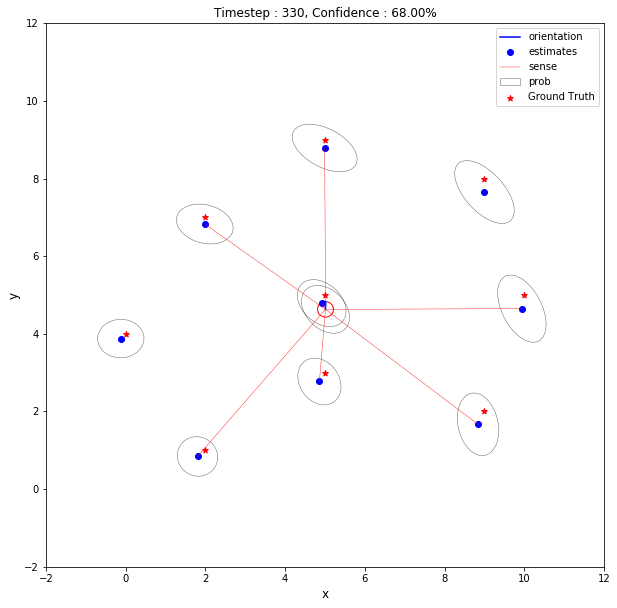

In [15]:
from plotting_tools.plotter import plot_and_save_state

# Resetting Values
sigma = np.r_[np.c_[sigma_mm,sigma_mn],np.c_[sigma_nm,sigma_nn]]
mu = np.zeros(m+b*n)
observedLandmarks = np.zeros(n)

# Implementing the EKF Algorithm
fig = plt.figure(figsize=(10,10))

# Defining Ellipse confidence. a value of 0.95 indicates that
# we are 95 % sure that the ground truth lies within the error ellipse
# default value is 0.95
prob = 0.68
for i in xrange(330): #each timestep
    mu , sigma = prediction(mu,sigma,odometry[i])
    mu, sigma = correction(mu,sigma,sensor[i],observedLandmarks)
    
    
    plot_and_save_state(mu,sigma,observedLandmarks,landmarks,get_ids(sensor[i]),i,prob)

In [16]:
import os
# Adding "echo 'y' |" sends and 'y' to the program if it asks permission
# to overwrite the video file if it already exists

program = 'echo "y" | ffmpeg -r 10  -i plots/ekf_%03d.png -b 500000 plots/ekf_slam.mp4'
success = os.system(program)
if(success != 0):
    print('''An error Occured. Please check if you have ffmpeg installed.\nTo install ffmpeg on Ubuntu : execute `sudo apt-get install ffmpeg` in shell.
For other OS, follow this link : https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg''')

In [22]:
%%HTML
<video width="800" height="800" controls autoplay>
  <source src="plots/ekf_slam.mp4" type="video/mp4">
</video>

In [24]:
error = []
for i in xrange(len(landmarks)):
    error.append(np.linalg.norm(np.array([mu[2*i+3],mu[2*i+4]])-\
                           np.array([landmarks.iloc[i]['x'],landmarks.iloc[i]['y']])))

print np.sum(error)

2.37541178507


# Discussion:

As we can see that the algorithm can acheive decent results. Although some estimates are still a little off like the landmarks on the right. This is because the Kalman Filter assumes Linearity of models(motion and observation) and Gaussian Distribution of errors. But since our models are composed of non-linear functions like sin and cosine functions, which are linearised by calculating Jacobians, the goodness of the results highly depends on the quality of linearisation.

Further, the quality of linearisation depends on two factors: **Level of uncertainity** and **Degree of local Linearity**.

This is explained in the figure below.

![local_linearity,Unceratinity](figures/stacked.png)

# References

The references folder has some good material on the SLAM problem generally.

The dataset used here has been taken from Freiburg University's Robotics Mapping Course Page.

http://ais.informatik.uni-freiburg.de/teaching/ws13/mapping/

The lectures for this page can be found on youtube.

https://www.youtube.com/watch?v=U6vr3iNrwRA&list=PLgnQpQtFTOGQrZ4O5QzbIHgl3b1JHimN_

Further, if interested in how to draw the iso-contours(probability ellipse) when dealing with Bivariate Gaussian Distribution, check the references for a guide and also check the code in plotting_tools folder.

Figures from the book **Probabilistic Robotics** by Sebastian Thurn, Wolfram Burgard and Dieter Fox.

http://www.probabilistic-robotics.org/